# [E-04]주식 예측에 도전해 보자

### Import

In [254]:
from pandas import DataFrame, Series
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf
from pandas_datareader import data as pdr

from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import os

import warnings
warnings.filterwarnings('ignore') #경고 무시

## STEP 1 : 시계열 데이터 준비

### 데이터 Read

In [255]:
data_path = os.getenv('homepath') + '/Desktop/python/exploration/exploration_11_11/005930.KS.csv'
ks_data = pd.read_csv(data_path)

print(type(ks_data))
ks_data.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
1,2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2,2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
3,2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
4,2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


Columns - Data, Open, Hihg, Low, Close, Adj Close, Volume

### 시계열 데이터로 변경

In [256]:
ks_t_data = pd.read_csv(data_path, index_col = 'Date', parse_dates = True)

print(type(ks_t_data))
ks_t_data.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [257]:
ks_t_data = ks_t_data['Close']

print(type(ks_t_data))
ks_t_data.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행

### 결측치 확인 및 처리

In [258]:
ks_t_data = ks_t_data.interpolate(method = 'time')
print(ks_t_data[ks_t_data.isna()])

ks_t_data.isnull().sum()

Series([], Name: Close, dtype: float64)


0

* ks_t_data에 만약 결측치가 있다면 보간 진행 후 결측값 series 데이터로 추출
* 결측치 0개로 없음 확인  


### 일반 데이터에서의 결측치 시각화

<AxesSubplot: >

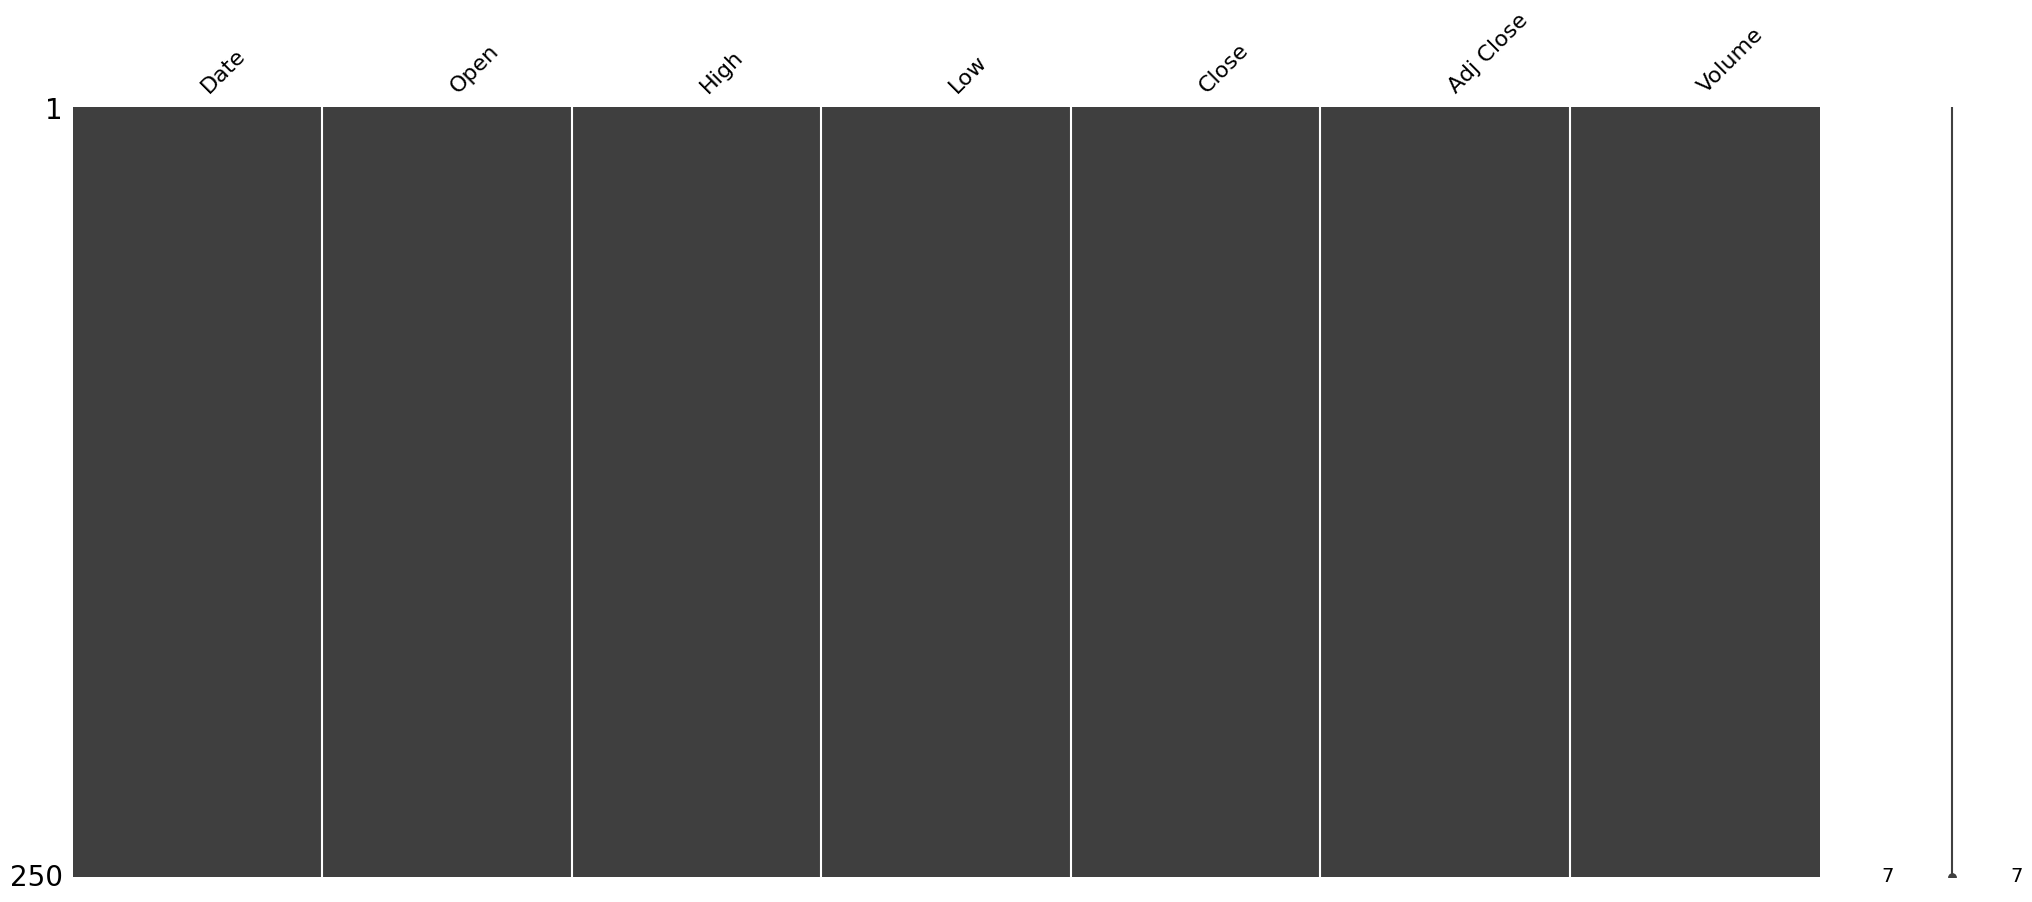

In [259]:
msno.matrix(ks_data)

### 로그변환

In [260]:
log_ks_t = np.log(ks_t_data)

log_ks_t

Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
                ...    
2021-05-12    11.289782
2021-05-13    11.270854
2021-05-14    11.291031
2021-05-17    11.284769
2021-05-18    11.284769
Name: Close, Length: 250, dtype: float64

## STEP 3 : 시계열 안정성 분석

### 시계열 Stationary 분석 데이터 시각화

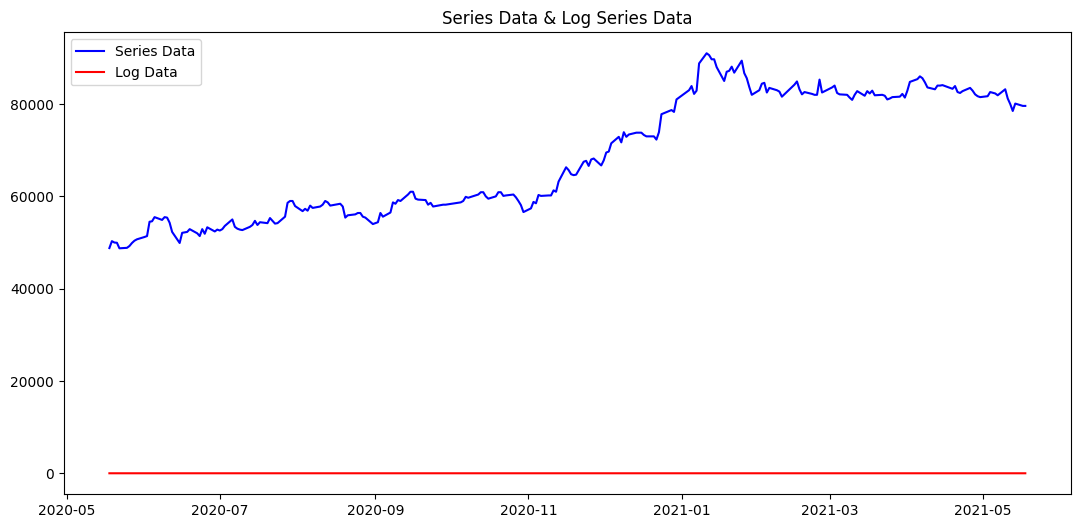

In [261]:
rcParams['figure.figsize'] = 13, 6

plt.plot(ks_t_data, color = 'blue', label = 'Series Data')
plt.plot(log_ks_t, color = 'red', label = 'Log Data')
plt.legend(loc = 'best')
plt.title('Series Data & Log Series Data')
plt.show(block = False)

### 구간 통계치(rolling_statistics) 시각화 함수 구현

In [262]:
def rolling_statistics(timeseries, window = 12):
    rolmean = timeseries.rolling(window = window).mean() # 이동평균 시계열
    rolstd = timeseries.rolling(window = window).std() # 이동표준편차 사계열

    #원본 시계열, 이동평균 시계열, 이동표준편차 시계열 시각화
    org = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'green', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)

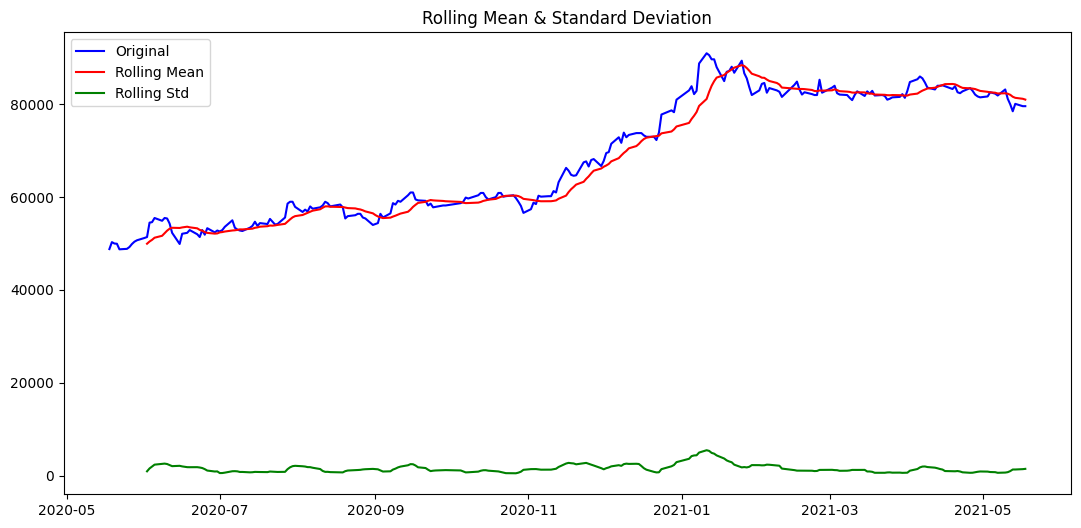

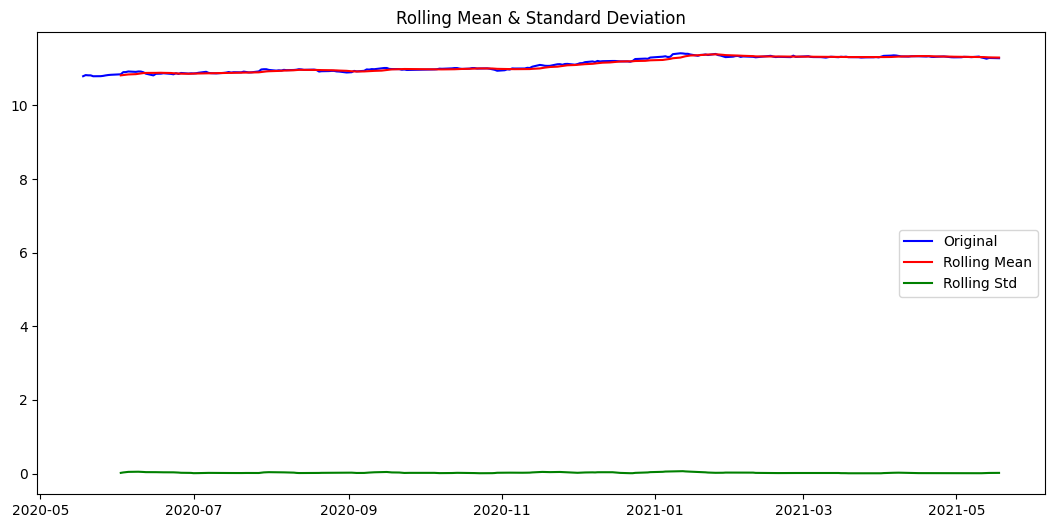

In [263]:
rolling_statistics(ks_t_data)
rolling_statistics(log_ks_t)

### 졍량적 Augmented Dickey-Fuller Test 함수 구현

In [264]:
def augmented_dickey_fuller_test(timeseries):
    
    # statsmodels 패키지 내의 adfuller 메서드
    dftest = adfuller(timeseries)

    # adfuller 가 return 시킨 결과값 출력
    print('Results of Dickey-fuller-test:')
    dfoutput = pd.Series(dftest[0 : 4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

* statsmodels 패키지 내의 adfuller 메서드 사용의 이유  
adfuller 함수안에 시계열 데이터를 넣을 경우엔 p-value, test-statistics, ciritical value, lag, observation 개수로  
결과값을 얻을 수 있어 종합적인 값도 중요하지만 p-value 값을 확인하기 위해 adfuller 함수를 이용해  
해당 시계열 데이터가 Stationary 데이터인지 아닌지를 확인할 수 있게 해줌 

In [265]:
augmented_dickey_fuller_test(ks_t_data)

Results of Dickey-fuller-test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


p-value 값이 1에 가까우므로 Non Stationay 한 시계열 데이터임을 확인

In [266]:
augmented_dickey_fuller_test(log_ks_t)

Results of Dickey-fuller-test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


Log 함수를 사용하지 않았을 때의 데이터보단 p-vlaue 값이 낮은것으로 확인 되었으나  
여전히 1에 가까우므로 Non Stationay 한 시계열 데이터

### 시계열 분해(Time Series Decomposition)

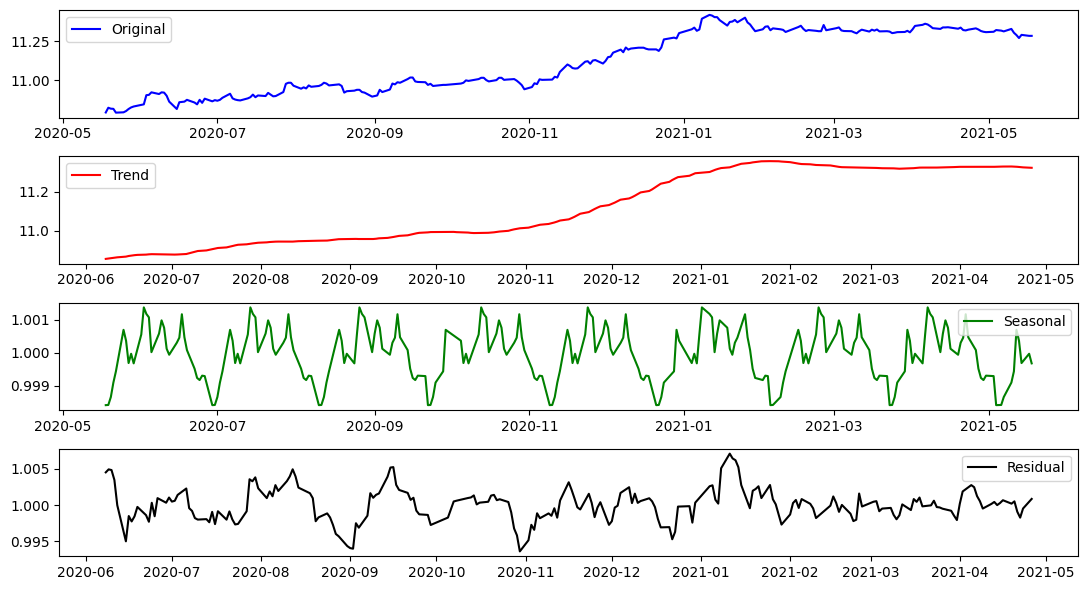

In [267]:
decomposition = seasonal_decompose(log_ks_t, model = 'multiplicative' , period = 30)

trend = decomposition.trend # 추세(시간 추이에 따른 평균값 변화)
seasonal = decomposition.seasonal # 계절성(주기적 변화)
residual = decomposition.resid # Log - 추세 - 계절성

plt.rcParams['figure.figsize'] = (11, 6)
plt.subplot(411)
plt.plot(log_ks_t, color = 'blue', label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, color = 'red', label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, color = 'green', label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, color = 'black', label = 'Residual')
plt.legend(loc = 'best')
plt.tight_layout()

Original - Trend - Seasonal = Residual 로 시계열을 분해하고 차분했을 때의 결과값은  
시각화 데이터로만 봤을 땐 Original 의 데이터보다 Residual 의 데이터가  
훨씬 Stationary 한 데이터로 보여지며 정말 Residual의 데이터가 Stationary한 데이터인지는  
안정성을 확인해야 할 것 같습니다.

### Residual 안정성 확인

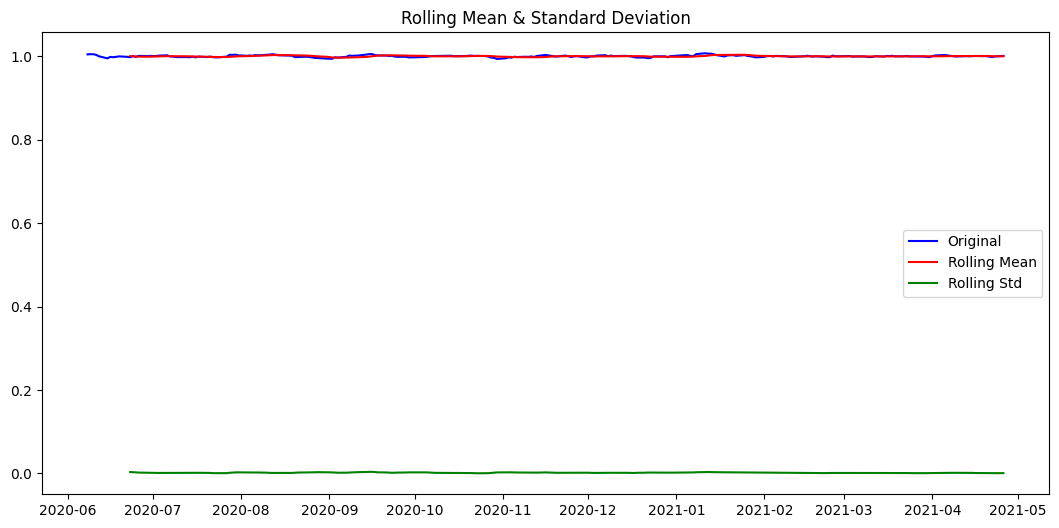

In [268]:
plt.rcParams['figure.figsize'] = (13, 6)

rolling_statistics(residual)

In [269]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-fuller-test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


p-value의 값이 6.234854e-08(= 0.00000006234854) 이므로 0.05 보다 낮은 값 (0에 가까운값) 에 해당  
귀무가설은 기각, 대립가설이 채택(= Stationary) 된 데이터이므로  
Residual 의 데이터는 Stationary 한 데이터이다.

## STEP 4 : 학습, 테스트 데이터셋 생성

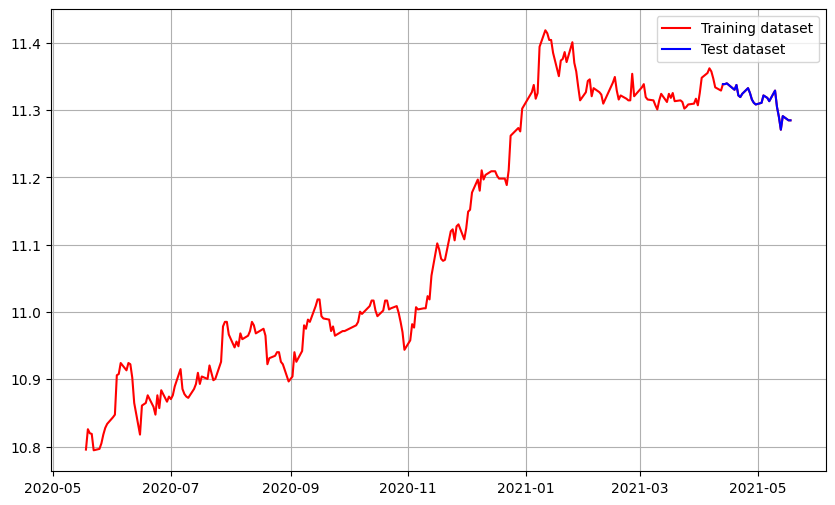

In [270]:
train_data, test_data = log_ks_t[:int(len(log_ks_t) * 0.9)], log_ks_t[int(len(log_ks_t) * 0.9) : ]

plt.figure(figsize = (10, 6))
plt.grid(True)
plt.plot(log_ks_t, color = 'red', label = 'Training dataset')
plt.plot(test_data, color = 'blue', label = 'Test dataset')
plt.legend()
plt.show()

## STEP 5 : 적정 ARIMA 모수 찾기

### ACF, PACF 그려보기 -> p,q 구하기

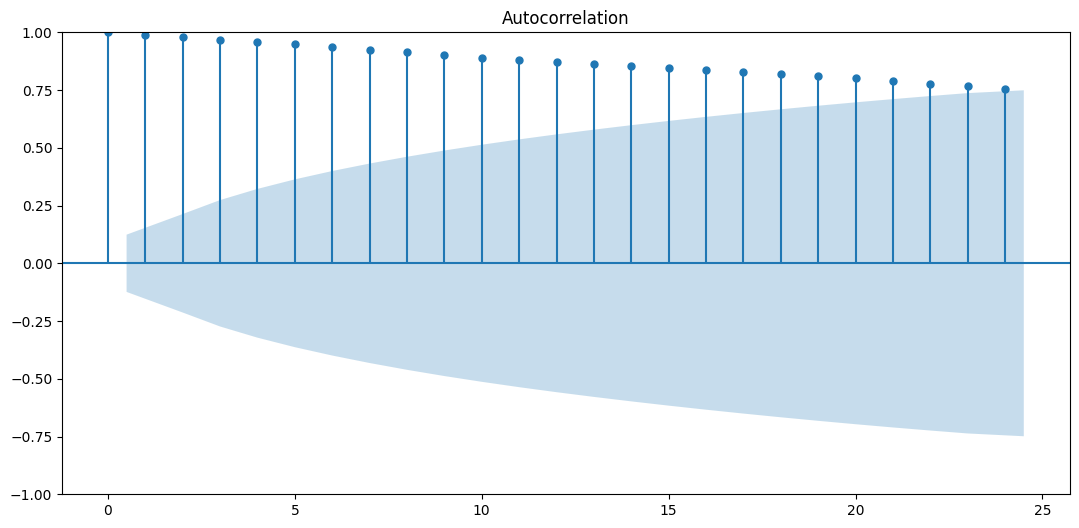

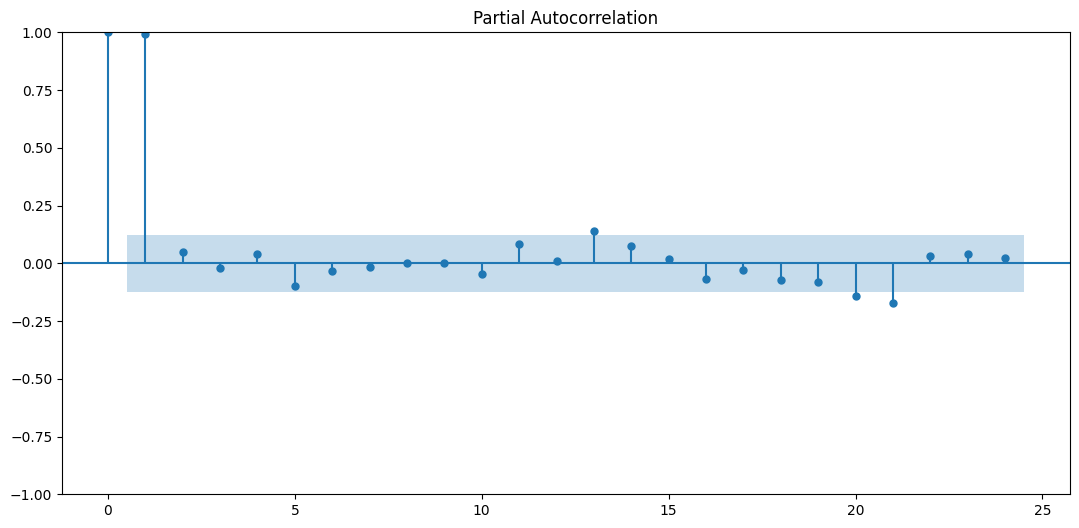

In [271]:
plot_acf(log_ks_t)
plot_pacf(log_ks_t)
plt.show()

그래프를 보고 알 수 있는 데이터  
AR(p) = 1  
2이상의 구간부터는 PACF가 거의 0에 가까워지고 있어 p = 1이 가장 적합  
MA(q) = 적합한 값이 없어 0으로 둘 수 있지만 여러가지 값으로 확인하여 가장 적합한 값을 찾아야함

### 차분 안정성 확인 -> d 구하기

Results of Dickey-fuller-test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


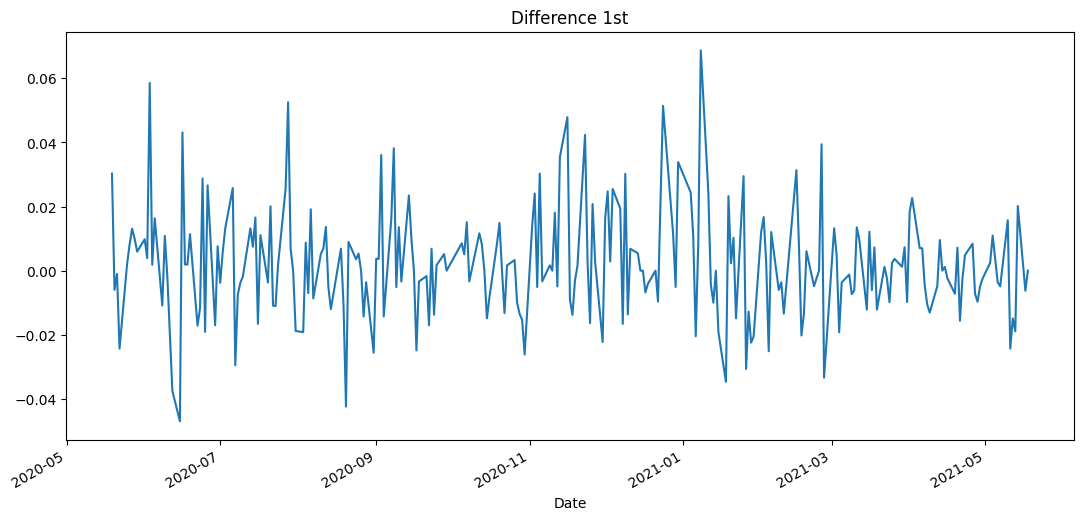

In [272]:
diff_1 = log_ks_t.diff(periods = 1).iloc[1: ]
diff_1.plot(title = 'Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차분의 결과  
p-value의 값이 2.183738e-28 (=0.0000000000000000000000000002183738) 이므로 0과 매우 가까운 값으로  
Stationary 한 값임을 확인

## STEP 6 : ARIMA 모델 훈련과 테스트

### ARIMA 모델객체 생성과 훈련

In [273]:
model = ARIMA(train_data, order = (2, 1, 0))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 583.501
Date:                Mon, 21 Nov 2022   AIC                          -1161.003
Time:                        22:34:33   BIC                          -1150.768
Sample:                             0   HQIC                         -1156.871
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0367      0.062      0.592      0.554      -0.085       0.158
ar.L2         -0.0112      0.076     -0.147      0.883      -0.160       0.138
sigma2         0.0003   2.47e-05     12.961      0.0

### 모델의 훈련 결과 시각화

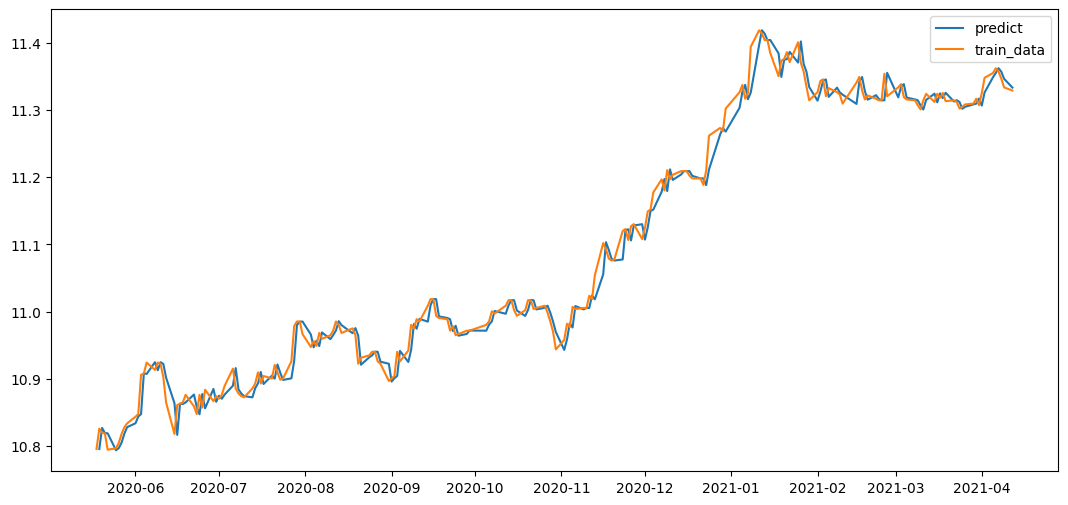

In [274]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])

plt.plot(fitted_m, label = 'predict')
plt.plot(train_data, label = 'train_data')
plt.legend()

### 모델 테스트 및 플로팅

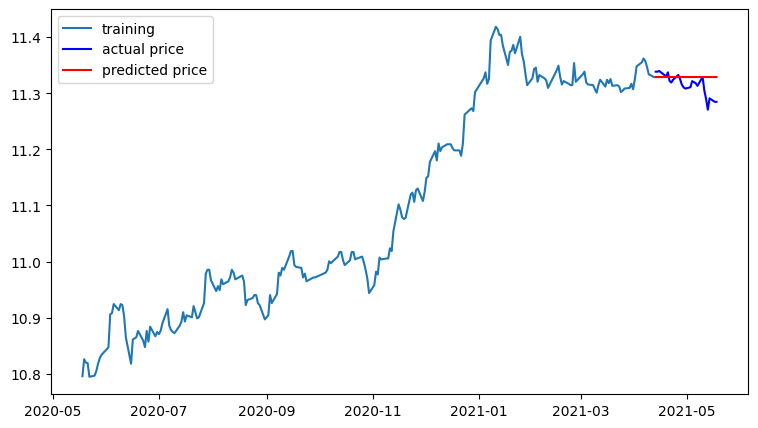

In [275]:
model = ARIMA(train_data, order = (2, 1, 0))
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha = 0.05)
fc = np.array(fc)
fc_series = pd.Series(fc, index = test_data.index)

plt.figure(figsize = (9, 5), dpi = 100)
plt.plot(train_data, label = 'training')
plt.plot(test_data, color = 'blue', label = 'actual price')
plt.plot(fc_series, color = 'red', label = 'predicted price')
plt.legend()
plt.show()

### 최종 예측 모델 정확도 측정(MAPE)

In [276]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3514270.8114496623
MAE:  1409.0883494018904
RMSE:  1874.6388482717578
MAPE: 1.74%


## 다른 주식 종목 예측해 보기

### (주)삼성전자 주식 확인

In [277]:
yf.pdr_override()

sm = pdr.get_data_yahoo('005930.KS', start='2021-11-10', end='2022-11-10')
sm.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245 entries, 2021-11-10 to 2022-11-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       245 non-null    float64
 1   High       245 non-null    float64
 2   Low        245 non-null    float64
 3   Close      245 non-null    float64
 4   Adj Close  245 non-null    float64
 5   Volume     245 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.4 KB


In [278]:
sm.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-10,70300.0,70900.0,70200.0,70200.0,68630.929688,9422009
2021-11-11,69900.0,70000.0,69600.0,69900.0,68337.625000,11489122
2021-11-12,70200.0,70900.0,69900.0,70600.0,69021.984375,10087450
2021-11-15,71700.0,71900.0,70900.0,71400.0,69804.109375,12420710
2021-11-16,71500.0,72000.0,71300.0,71300.0,69706.335938,10919239


In [279]:
sm = sm['Close']
sm.head()

Date
2021-11-10    70200.0
2021-11-11    69900.0
2021-11-12    70600.0
2021-11-15    71400.0
2021-11-16    71300.0
Name: Close, dtype: float64

### 결측치 처리

In [280]:
sm = sm.interpolate(method='time')
sm[sm.isna()]

Series([], Name: Close, dtype: float64)

### 로그변환

In [281]:
sm_log = np.log(sm)

### 정성적 그래프 분석

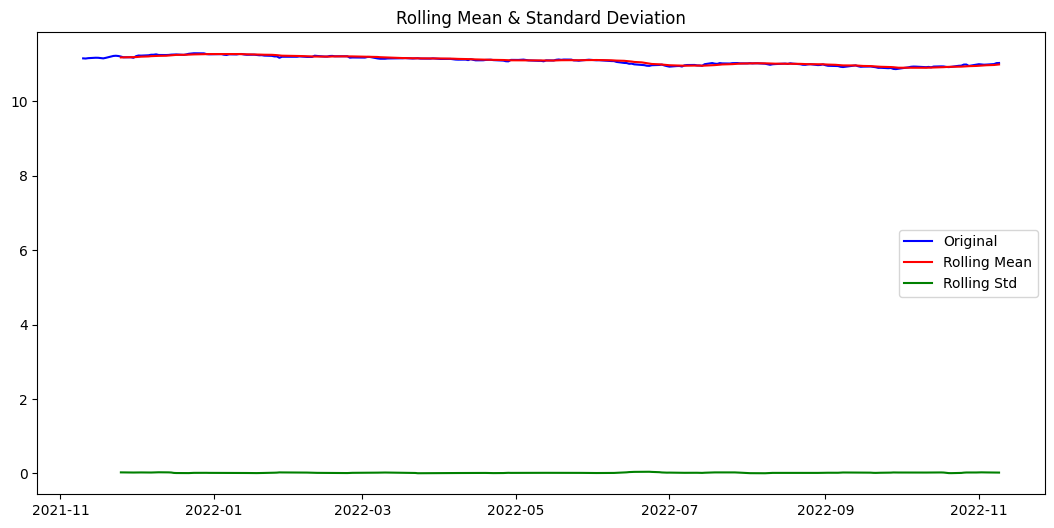

In [282]:
rolling_statistics(sm_log, window=12)

### 정량적 Augmented Dicky-Fuller Test

In [283]:
augmented_dickey_fuller_test(sm_log)

Results of Dickey-fuller-test:
Test Statistic                  -0.994521
p-value                          0.755257
#Lags Used                       0.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


### 시계열 분해(Time Series Decomposition)

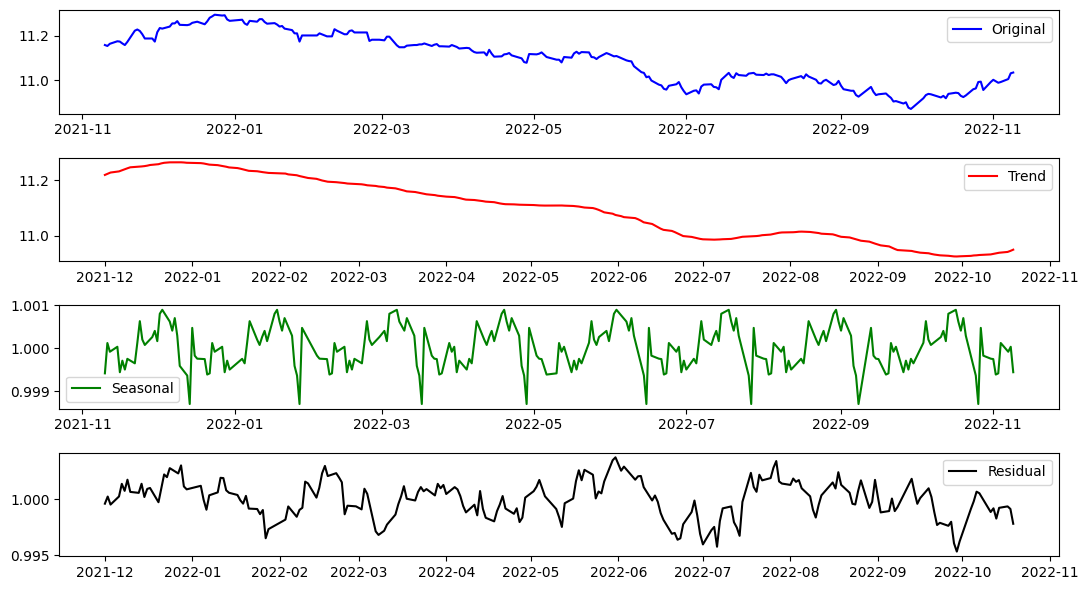

In [284]:
decomposition = seasonal_decompose(sm_log, model = 'multiplicative' , period = 30)

trend = decomposition.trend # 추세(시간 추이에 따른 평균값 변화)
seasonal = decomposition.seasonal # 계절성(주기적 변화)
residual = decomposition.resid # Log - 추세 - 계절성

plt.rcParams['figure.figsize'] = (11, 6)
plt.subplot(411)
plt.plot(sm_log, color = 'blue', label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, color = 'red', label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, color = 'green', label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, color = 'black', label = 'Residual')
plt.legend(loc = 'best')
plt.tight_layout()

### Residual 안정성 확인

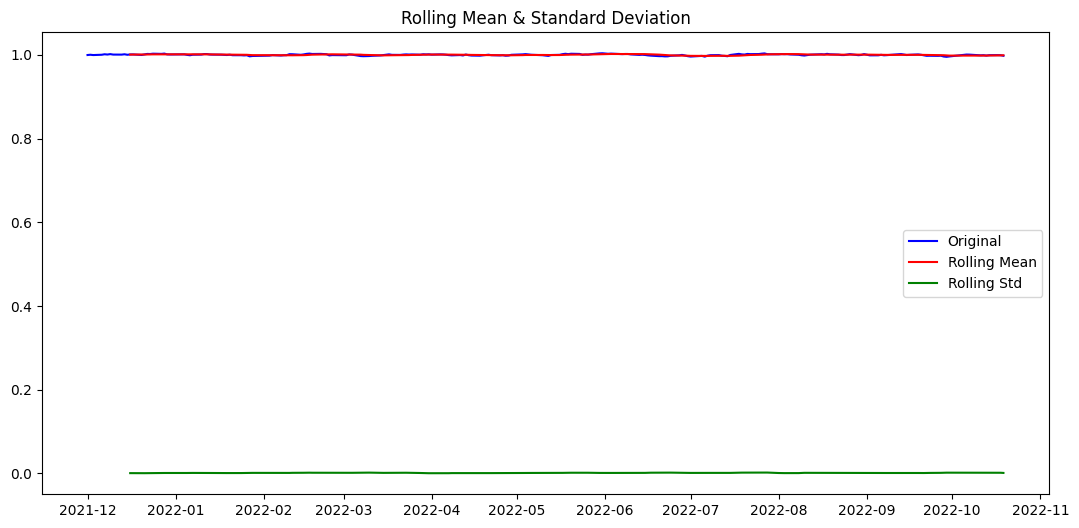

In [285]:
plt.rcParams['figure.figsize'] = (13, 6)

rolling_statistics(residual)

In [286]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-fuller-test:
Test Statistic                  -5.102778
p-value                          0.000014
#Lags Used                       1.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


### 학습, 테스트 데이터셋 분리

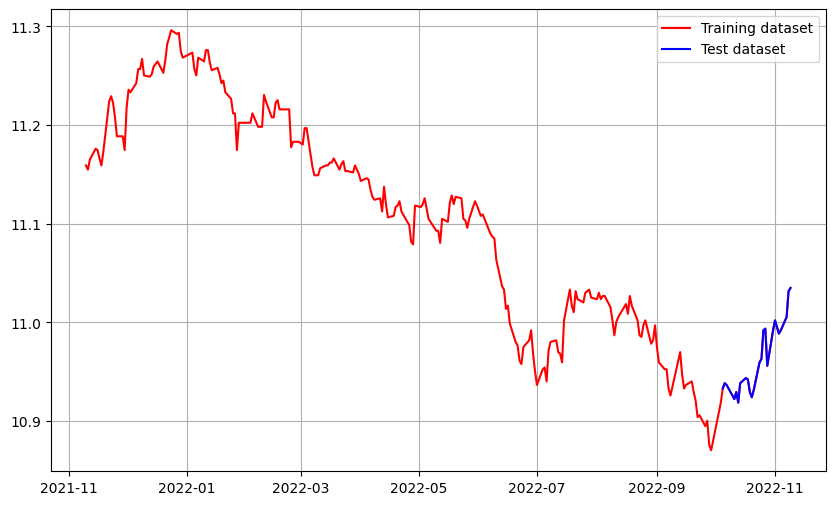

In [287]:
train_data, test_data = sm_log[:int(len(sm_log) * 0.9)], sm_log[int(len(sm_log) * 0.9) : ]

plt.figure(figsize = (10, 6))
plt.grid(True)
plt.plot(sm_log, color = 'red', label = 'Training dataset')
plt.plot(test_data, color = 'blue', label = 'Test dataset')
plt.legend()
plt.show()

### ACF, PACF 그려보기 -> p,q 구하기

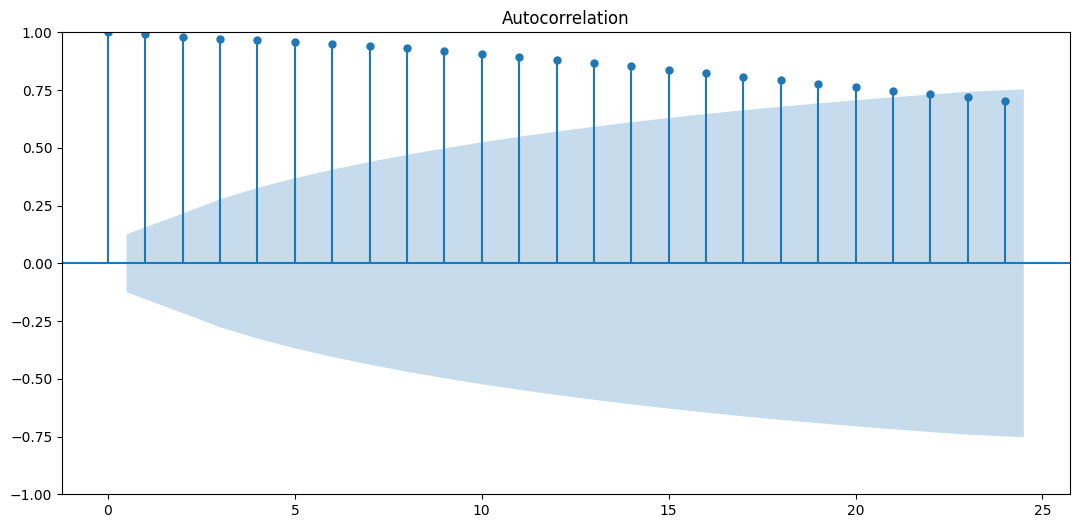

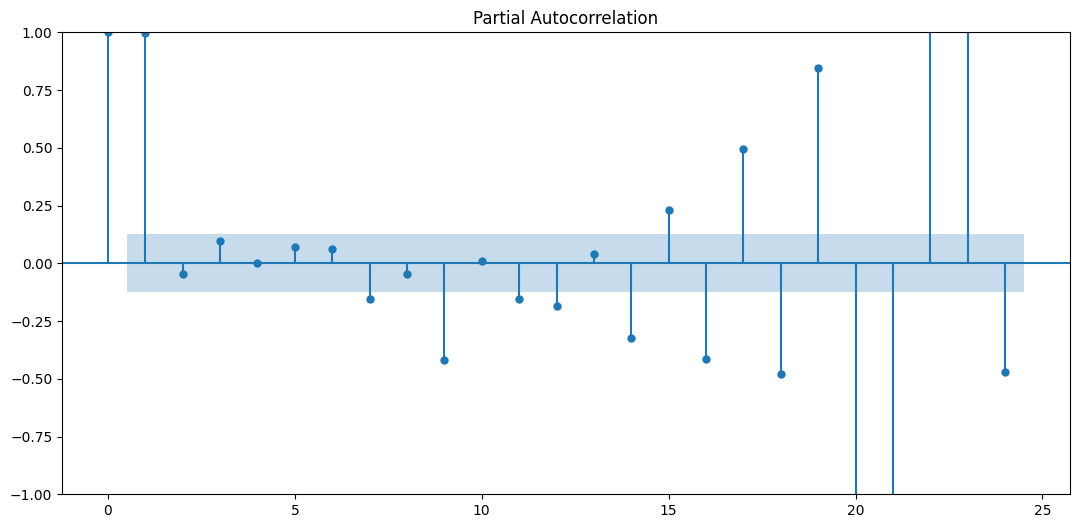

In [288]:
plot_acf(sm_log)
plot_pacf(sm_log)
plt.show()

### 차분 안정성 확인 -> d 구하기

Results of Dickey-fuller-test:
Test Statistic                -1.201914e+01
p-value                        3.052407e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


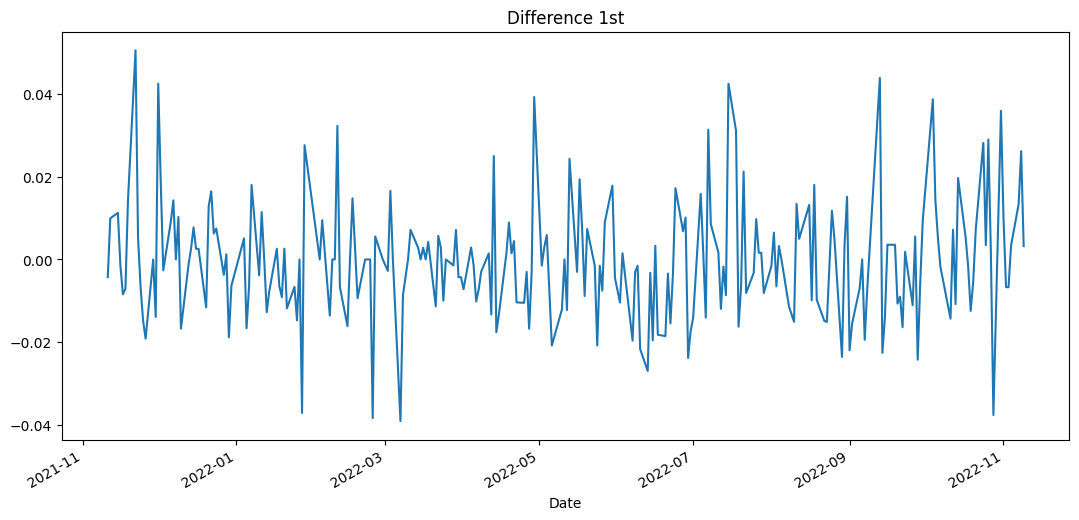

In [289]:
diff_1 = sm_log.diff(periods = 1).iloc[1: ]
diff_1.plot(title = 'Difference 1st')

augmented_dickey_fuller_test(diff_1)

### ARIMA 모델객체 생성과 훈련

In [290]:
model = ARIMA(train_data, order = (2, 1, 0))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  220
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 623.228
Date:                Mon, 21 Nov 2022   AIC                          -1240.455
Time:                        22:34:37   BIC                          -1230.288
Sample:                             0   HQIC                         -1236.349
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0303      0.067      0.452      0.651      -0.101       0.162
ar.L2         -0.1123      0.081     -1.391      0.164      -0.271       0.046
sigma2         0.0002   1.48e-05     13.296      0.0

### 모델 훈련 시각화

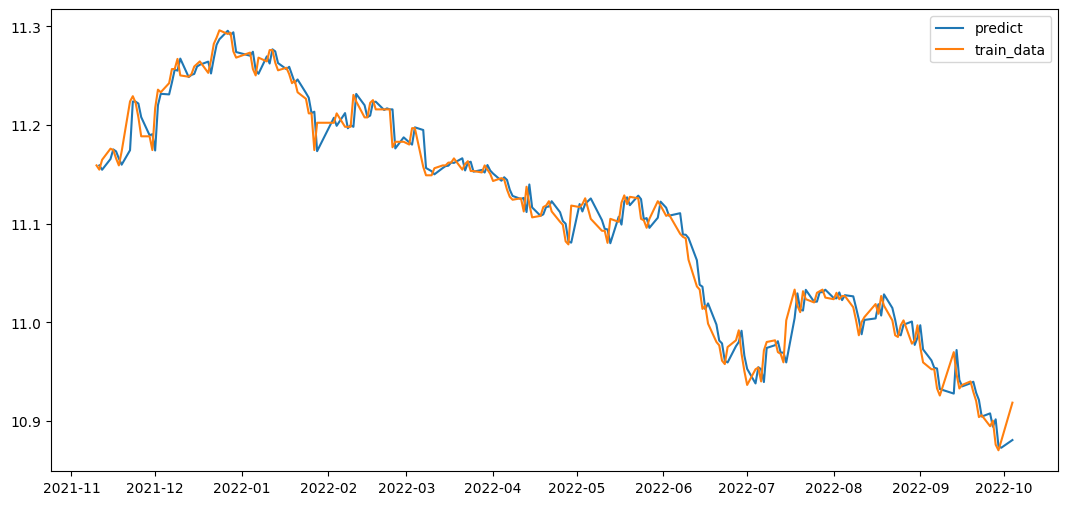

In [291]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])

plt.plot(fitted_m, label = 'predict')
plt.plot(train_data, label = 'train_data')
plt.legend()

### 모델 테스팅 및 플로팅

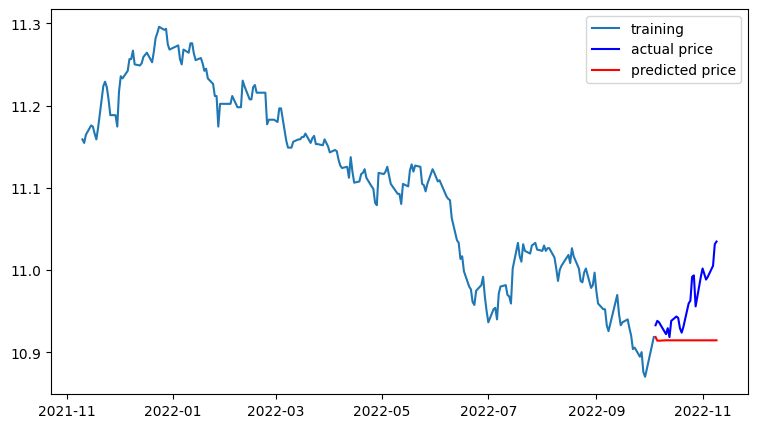

In [292]:
model = ARIMA(train_data, order = (2, 1, 0))
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha = 0.05)
fc = np.array(fc)
fc_series = pd.Series(fc, index = test_data.index)

plt.figure(figsize = (9, 5), dpi = 100)
plt.plot(train_data, label = 'training')
plt.plot(test_data, color = 'blue', label = 'actual price')
plt.plot(fc_series, color = 'red', label = 'predicted price')
plt.legend()
plt.show()

### 최종 예측 모델 정확도 측정(MAPE)

In [293]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  11933921.881629204
MAE:  2788.7179531405145
RMSE:  3454.5508943463556
MAPE: 4.71%


## 다른 주식 종목 예측해 보기2

### Apple 주식 확인

In [294]:
yf.pdr_override()

apple = pdr.get_data_yahoo('AAPL', start='2021-11-10', end='2022-11-10')
apple.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2021-11-10 to 2022-11-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       252 non-null    float64
 1   High       252 non-null    float64
 2   Low        252 non-null    float64
 3   Close      252 non-null    float64
 4   Adj Close  252 non-null    float64
 5   Volume     252 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.8 KB


In [295]:
apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-10,150.020004,150.130005,147.850006,147.919998,147.066452,65187100
2021-11-11,148.960007,149.429993,147.679993,147.869995,147.016754,41000000
2021-11-12,148.429993,150.399994,147.479996,149.990005,149.124527,63804000
2021-11-15,150.369995,151.880005,149.429993,150.000000,149.134460,59222800
2021-11-16,149.940002,151.490005,149.339996,151.000000,150.128677,59256200


In [296]:
apple = apple['Close']
apple.head()

Date
2021-11-10    147.919998
2021-11-11    147.869995
2021-11-12    149.990005
2021-11-15    150.000000
2021-11-16    151.000000
Name: Close, dtype: float64

### 결측치 처리

In [297]:
apple = apple.interpolate(method='time')
apple[apple.isna()]

Series([], Name: Close, dtype: float64)

### 로그 변환

In [298]:
log_apple = np.log(apple)

### 정성적 그래프 분석

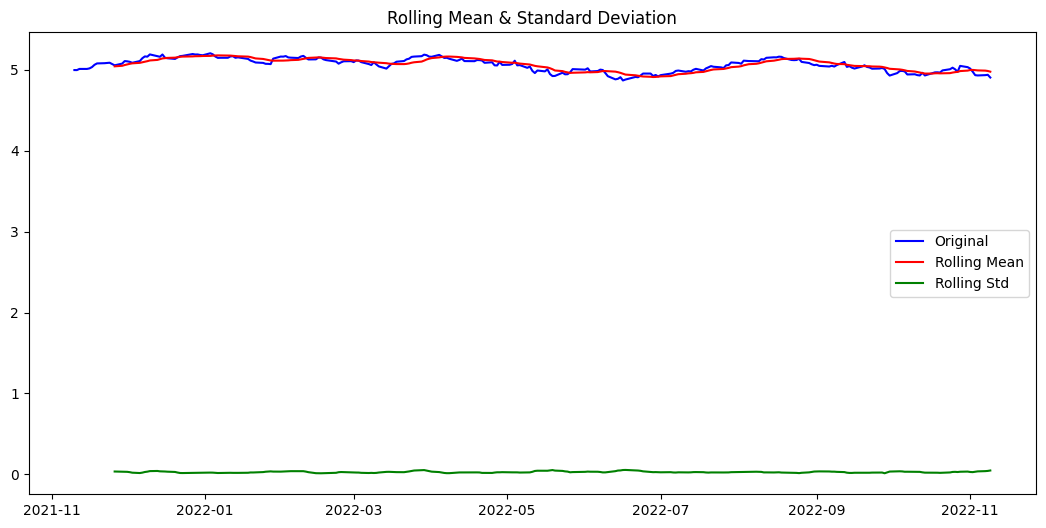

In [299]:
rolling_statistics(log_apple, window=12)

### 정량적 Augmented Dicky-Fuller Test

In [300]:
augmented_dickey_fuller_test(log_apple)

Results of Dickey-fuller-test:
Test Statistic                  -1.755644
p-value                          0.402695
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


### 시계열 분해(Time Series Decomposition)

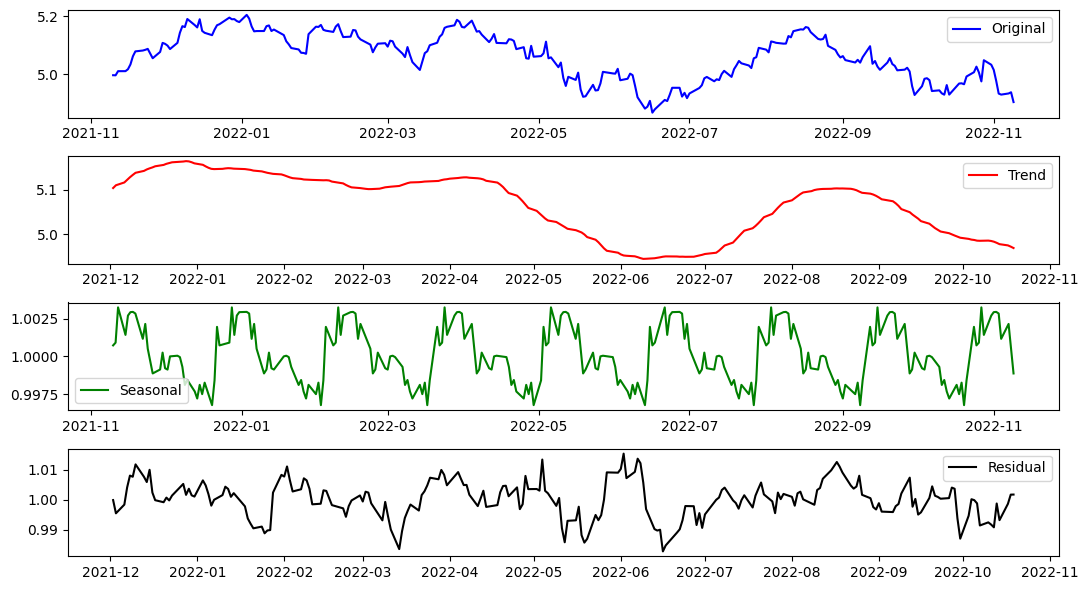

In [301]:
decomposition = seasonal_decompose(log_apple, model = 'multiplicative' , period = 30)

trend = decomposition.trend # 추세(시간 추이에 따른 평균값 변화)
seasonal = decomposition.seasonal # 계절성(주기적 변화)
residual = decomposition.resid # Log - 추세 - 계절성

plt.rcParams['figure.figsize'] = (11, 6)
plt.subplot(411)
plt.plot(log_apple, color = 'blue', label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, color = 'red', label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, color = 'green', label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, color = 'black', label = 'Residual')
plt.legend(loc = 'best')
plt.tight_layout()

### Residual 안정성 확인

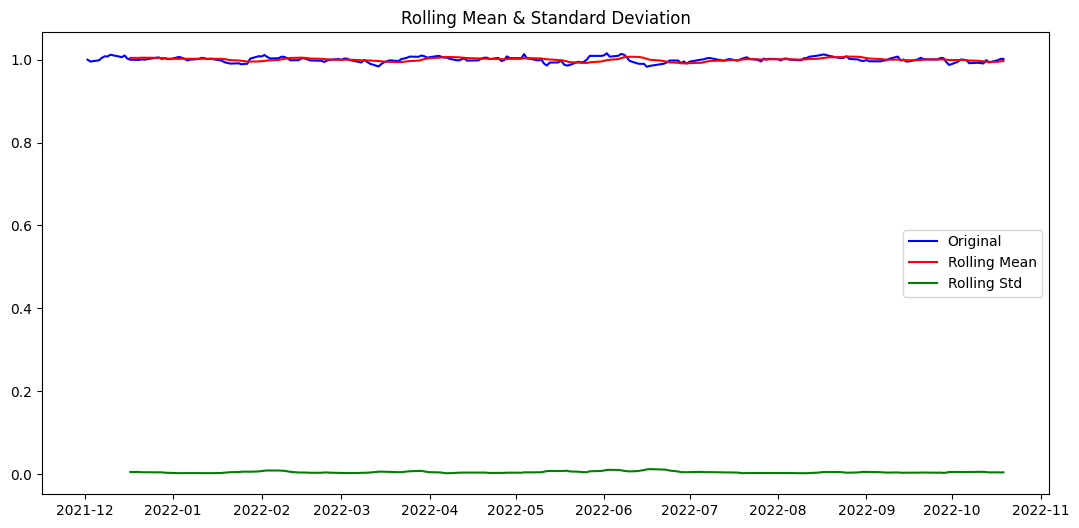

In [302]:
plt.rcParams['figure.figsize'] = (13, 6)

rolling_statistics(residual)

### 학습, 테스트 데이터셋 분리

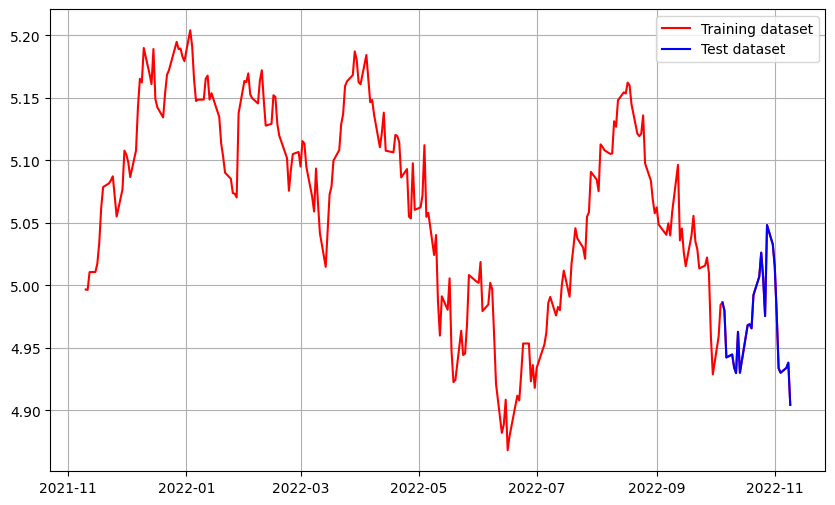

In [303]:
train_data, test_data = log_apple[:int(len(log_apple) * 0.9)], log_apple[int(len(log_apple) * 0.9) : ]

plt.figure(figsize = (10, 6))
plt.grid(True)
plt.plot(log_apple, color = 'red', label = 'Training dataset')
plt.plot(test_data, color = 'blue', label = 'Test dataset')
plt.legend()
plt.show()

### ACF, PACF 그려보기 -> p,q 구하기

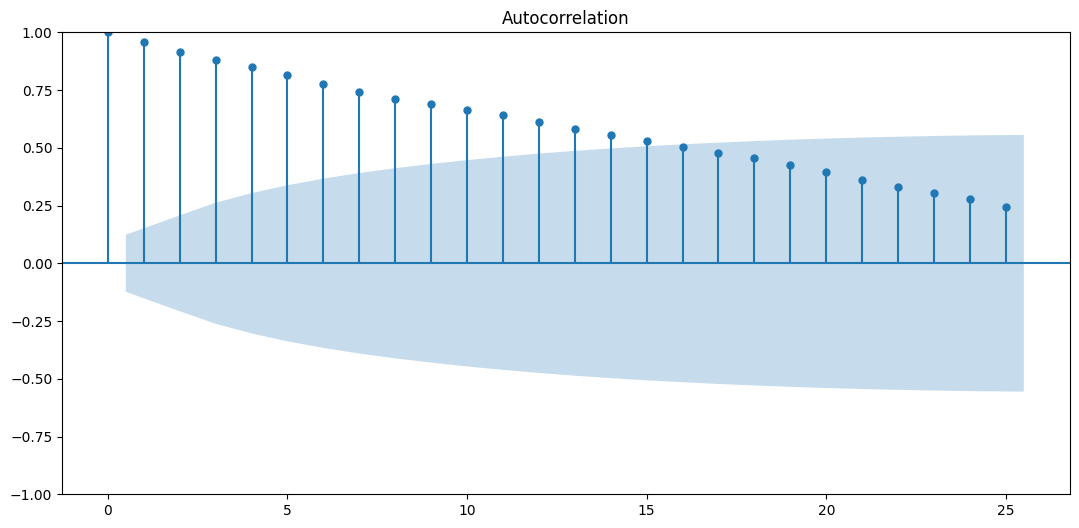

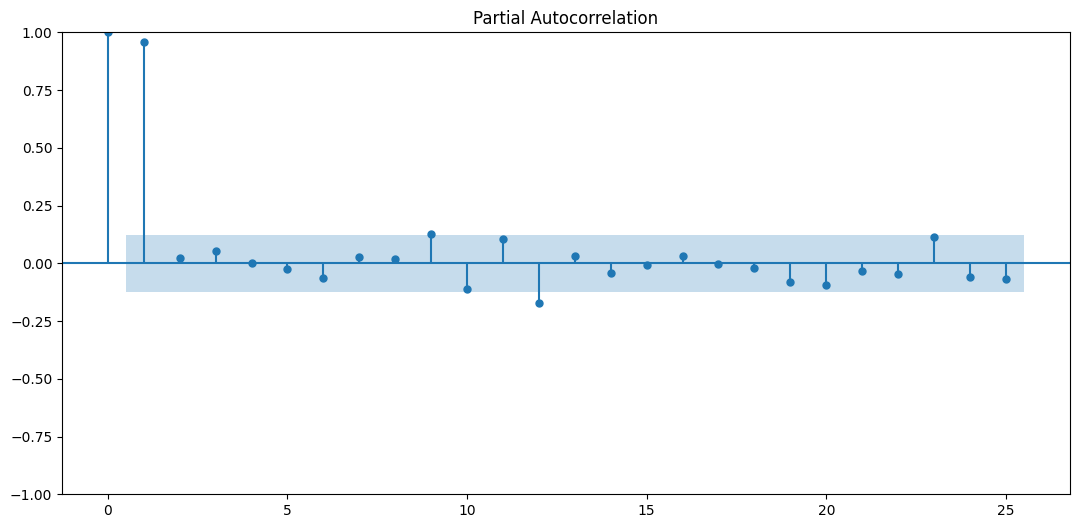

In [304]:
plot_acf(log_apple)
plot_pacf(log_apple)
plt.show()

### 차분 안정성 확인 -> d 구하기

Results of Dickey-fuller-test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


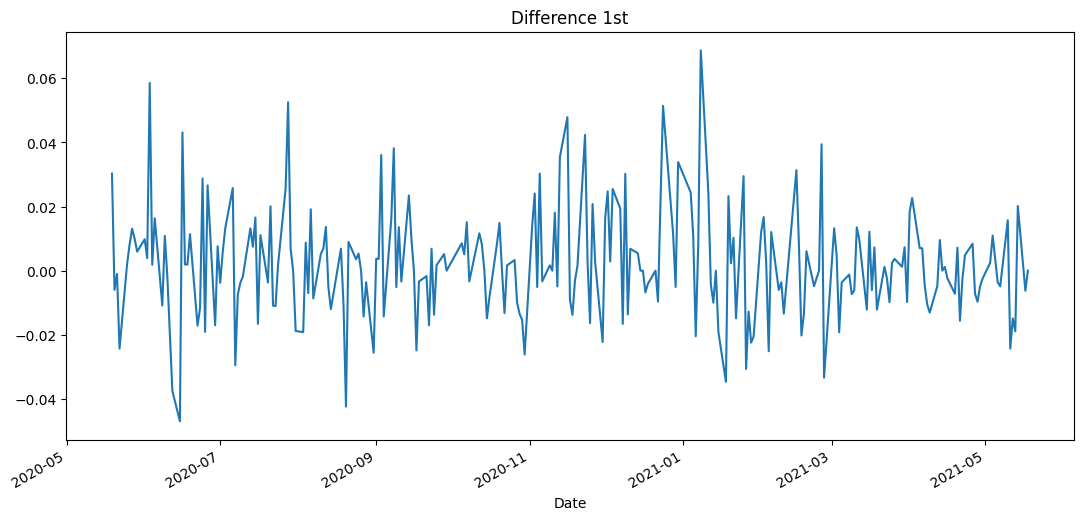

In [305]:
diff_1 = log_ks_t.diff(periods = 1).iloc[1: ]
diff_1.plot(title = 'Difference 1st')

augmented_dickey_fuller_test(diff_1)

### ARIMA 모델 빌드와 훈련

In [306]:
model = ARIMA(train_data, order = (2, 1, 0))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 549.929
Date:                Mon, 21 Nov 2022   AIC                          -1093.859
Time:                        22:34:41   BIC                          -1083.611
Sample:                             0   HQIC                         -1089.723
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0068      0.064      0.106      0.915      -0.119       0.133
ar.L2         -0.0832      0.066     -1.254      0.210      -0.213       0.047
sigma2         0.0004    4.1e-05     10.750      0.0

### 모델 테스트 및 플로팅

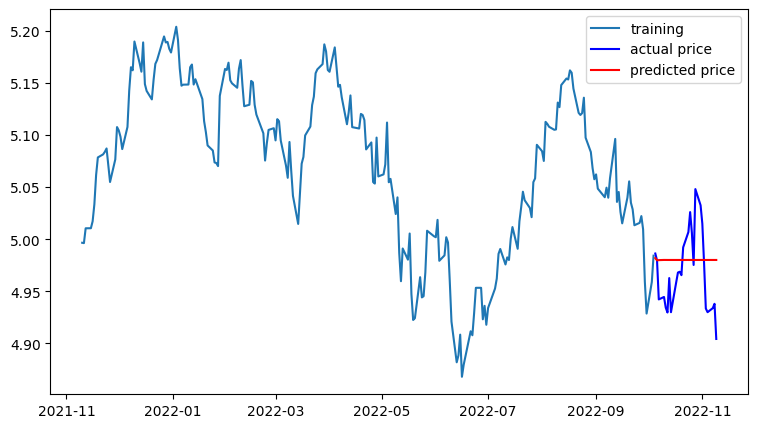

In [307]:
model = ARIMA(train_data, order = (2, 1, 0))
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha = 0.05)
fc = np.array(fc)
fc_series = pd.Series(fc, index = test_data.index)

plt.figure(figsize = (9, 5), dpi = 100)
plt.plot(train_data, label = 'training')
plt.plot(test_data, color = 'blue', label = 'actual price')
plt.plot(fc_series, color = 'red', label = 'predicted price')
plt.legend()
plt.show()

### 최종 예측 모델 정확도 측정(MAPE)

In [308]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  30.24166827149564
MAE:  4.644709365301703
RMSE:  5.499242517974238
MAPE: 3.24%


## 참고문헌 Reference

[statsmodels 0.14.0](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)  
[지수 표기법 (Exponential notaion) feat. vim: e+01, e-01](https://seulcode.tistory.com/461)  
[Augmented Dickey-fuller test - Stationary 확인](https://hongl.tistory.com/98)  
그루/김지수 님의 yfinance

## 회고

처음엔 새로운 주식에 대한 정보를 어디서 가져와야하며 파일을 어떻게 저장하고 리드를 해야하는지 계속 찾아봐도 나오질 않았으나  
오픈카카오톡 방에서 그루/김지수님께서 yfinance 를 이용하면 주식을 가져올 수 있다는 얘기를 공유해주셔서  
덕분에 길을 잃지 않고 원하는 삼성주식과 Apple 주식을 찾아 데이터프레임으로 변경했으며  
성공적으로 이번 프로젝트를 진행하게 됐습니다.  
  
1. 시계열 데이터 준비  
  
시계열 데이터 준비에서 처음 파일을 받아 read_csv로 read 했을 땐 처음으로 pd.DataFrame 파라미터로 인데스값을 지정해줄 수 있다는  
사실을 처음 알게 되었으며 인덱스값을 date로 지정해 시계열 데이터로 성공적으로 만들 수 있었습니다.  
  
2. 각종 전처리 수행  
  
이번달은 하루가 멀다하고 거의 매번 데이터 전처리를 진행하면서 전처리에 대해서 익숙해지는 시간이라고 느껴질정도로 전처리를  
많이 한 것 같았고 실제로도 처음보다는 데이터를 바라보는 시각 또는 방향, 그리고 전처리 방법에 대해서는 익숙해져서  
데이터 전처리에 대해서는 거부감 없이 잘 진행하고 처음보단 성공적으로 진행 됐었습니다.  
  
3. 시계열 안정성 분석  
  
시계열이 과연 Stationary 한 데이터인지 여러방면에서 확인하는 방법을 이번 프로젝트 시간에 알 수 있었으며  
정성적 그래프 분석, 정량적 Augmented Dicky-Fuller Test, 시계열 분해(Time Series Decomposition), Residual 안정성 확인을 통해  
데이터가 Stationary 한지 아닌지를 직접 눈으로 보고 판단할 수 있었습니다.  
  
4. 학습, 테스트 데이터셋 생성  
  
기존 학습, 데이터 테이터셋을 생성한다고 했었다면 X_train, X_test, y_train, y_test 이런식으로만 진행해왔어서 이번에도  
학습, 데이트 데이터셋을 생성할때도 동일하게 생성하고 진행하는 줄 알았으나 처음보는 전혀 다른 방식으로  
학습, 데이트 데이터셋을 생성했었으며 모든 데이터가 동일하게 학습, 테스트 데이터셋을 생성하는게 아니라는것을 알 수 있었습니다.  
또한, 이번 프로젝트에선 시각적으로 직접 보면서 진행하는 내용이 많았다보니 주식에 대해서 평소에 관심이 많았었는데  
해당 프로젝트를 진행하면서 정말 주식을 보는듯한 신기한 기분이 들어 재미있었습니다.  
  

5. 적정 ARIMA 모수 찾기  
  
사실 이번 프로젝트 내에서 아직까지도 명확하게 이해하지 못하고 있는 내용입니다.  
어찌저찌 적정 모수는 찾아서 진행을 하긴 했지만... p값, q값 그리고 d값을 적정한 값으로 어떻게 찾아야하는지  
그래프만 보고서는 정확한 내용을 이해하기 어려웠으며 해당 내용에 대해서는 추가 공부가 필요하다 싶다 라는 생각이 들었으며  
p,q,d 에 대한 적정한 값만 찾는 방법을 알게 된다면 좀더 수월하게 이번 프로젝트를 여러 방향으로 진행해보지 않았을까 하는  
아쉬움이 많이 남는 그런 파트였습니다.  
  
6. ARIMA 모델 훈련과 테스트  
  
지금까지의 데이터전처리, 학습, 테스트 데이터셋 생성, ARIMA 모수찾기 등.. 모두 이번 ARIMA모델에 대입하기 위한 준비재료였으며  
마지막 결과값을 눈으로 볼 수 있게 ARIMA 모델을 테스트하고 플로팅을 해봄으로써 미래의 주식을 알게된다면 이런게 아닐까  
하는 생각을 들게 해주었으며 아쉽게도 미래는 예측하긴 어렵지만 그래도 과거의 데이터만으로도 미래의 내용을  
조금이나마 예측을 해볼 수 있었다는게 많이 신기했었던 파트였습니다.